# Grab land cover for specified extent
Say you want to grab land cover data for a specific location, but you don't want to download the entire NLCD dataset to do that. The ArcGIS Python API can help!

Here I present an example of doing just that. The steps involve:
* Prepping for the analysis: importing modules and authenticating our arcgis session
* Locating the land cover data **item** and creating a **imagery layer** from it
* 

*Resource: https://developers.arcgis.com/python/guide/raster-analysis-advanced-concepts/*

### Prepping for analysis: importing and authenticating
* Import the the arcgis `GIS` module. We're going to do some geocoding so we need to create the arcgis `geocoding` module as well. Lastly, enable the Jupyter `display` object

In [1]:
#Import the GIS object.  and display modules
from arcgis import GIS
from arcgis.geocoding import geocode
from IPython.display import display, Image

* Authenticate our GIS object using our ArcGIS Pro account

In [2]:
#Create the GIS object, authenticating with your ArcGIS Pro account
gis = GIS('pro')

### Searching for the content and linking to it
What we want is 2011 NLCD data, provided as an *image service* (i.e. as a raster). You could search for the data from within ArcGIS Pro or via the [ArcGIS Online](http://www.arcgis.com) website, but we'll do it right here. 

Like any web search, it's a bit of an art knowing how best to locate the resource you want. At play are what general search keywords to include, and specific categories like `owner` or `item-type` to invoke. We do, however, want to search outside the Duke Community, we we want to include `outside_org=True`. 

I've decided to use `NLCD 2011` as a general search term, filter results for only those that `esri` provides, and limit results to image services: 

In [3]:
#Search for land cover and print the number of results
lc_results = gis.content.search("NLCD 2011, owner:esri",item_type='image',outside_org=True)
len(lc_results)

10

► This gives us 10 results, enough to show a list...

In [4]:
#Show a complete list of results
lc_results

[<Item title:"USA NLCD Tree Canopy Cover 2011 (Mature Support)" type:Imagery Layer owner:esri>,
 <Item title:"USA NLCD Land Cover 2011" type:Imagery Layer owner:esri>,
 <Item title:"USA NLCD Land Cover 2011 (Mature Support)" type:Imagery Layer owner:esri>,
 <Item title:"USA NLCD Landscape (Mature Support)" type:Imagery Layer owner:esri>,
 <Item title:"USA NLCD Impervious Surfaces 2011 (Mature Support)" type:Imagery Layer owner:esri>,
 <Item title:"USA NLCD Land Cover Change 2006-2011 (Mature Support)" type:Imagery Layer owner:esri>,
 <Item title:"USA NLCD Tree Canopy Cover 2011" type:Imagery Layer owner:esri>,
 <Item title:"USA NLCD Impervious Surface 2011" type:Imagery Layer owner:esri>,
 <Item title:"USA NLCD Impervious Surface Change 2006-2011" type:Imagery Layer owner:esri>,
 <Item title:"USA NLCD Impervious Change 2006-2011 (Mature Support)" type:Imagery Layer owner:esri>]

* The *second* item is the one we want. Let's store that as a variable named `lc_item`. 

In [5]:
#Get the second result and view what kind of object it is. 
lc_item = lc_results[1]
type(lc_item)

arcgis.gis.Item

<Item title:"USA NLCD Land Cover 2011" type:Imagery Layer owner:esri>
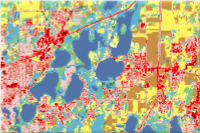

In [6]:
#Now let's view the item...
lc_item

* Let's examine a few **properties** of this item. Because arcgis Item objects are dynamic (they can be vector or raster or...) the list of what properties can change. But we can get a list of properies via the `item.keys()` function:

In [7]:
#List the property keys associated with the item we fetched
lc_item.keys()

dict_keys(['id', 'owner', 'created', 'modified', 'guid', 'name', 'title', 'type', 'typeKeywords', 'description', 'tags', 'snippet', 'thumbnail', 'documentation', 'extent', 'categories', 'spatialReference', 'accessInformation', 'licenseInfo', 'culture', 'properties', 'url', 'proxyFilter', 'access', 'appCategories', 'industries', 'languages', 'largeThumbnail', 'banner', 'screenshots', 'listed', 'numComments', 'numRatings', 'avgRating', 'numViews', 'contentStatus', 'orgId', 'scoreCompleteness', 'groupDesignations', 'layers', 'tables'])

* Let's examine the services' web address or its *URL*. Open this URL in your web browser. (Note, you'll have to authenticate as this layer is only available to ESRI license holders!) 

In [8]:
#Get the URL
print(lc_item['url']) #we could also use lc_item.url

https://landscape10.arcgis.com/arcgis/rest/services/USA_NLCD_Land_Cover_2011/ImageServer


* Down the road, we may need the image's **spatial reference**, so let's store that as a variable.

In [9]:
#Extract the image service's spatial reference to a variable
lc_sr = lc_item.spatialReference
lc_sr

'102100'

### From *arcgis* [`item`](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.gis.toc.html#item) to *arcgis* [`layer`](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.gis.toc.html#layer) (specifically an [`imagery layer`](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.raster.toc.html#imagerylayer))

* Now we need to extract the data **layer** from the data **item**. The `layers` property returns a list of layers associated with this image service, of which there is only one. So we extract that one to a new variable called `lc_lyr`...<br>*Calling this variable displays it to our notebook!*

In [10]:
#Extract the one (and only) layer in the item to a new variable and display it
lc_lyr = lc_item.layers[0]
type(lc_lyr)

arcgis.raster._layer.ImageryLayer

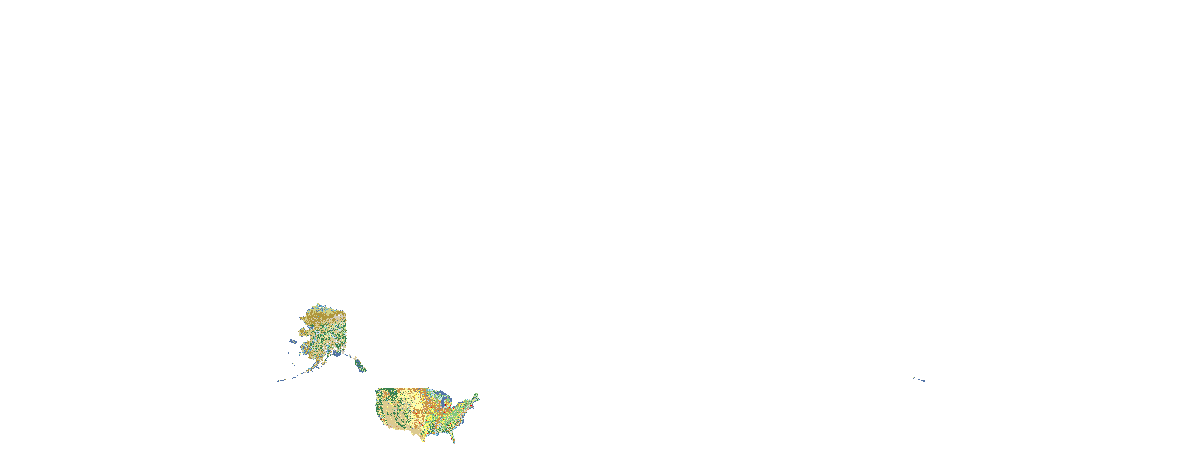

In [11]:
lc_lyr

In [12]:
#What are the pixel sizes in the X and Y direction? 
xPixelSize = lc_lyr.properties.pixelSizeX
yPixelSize = lc_lyr.properties.pixelSizeY
print(xPixelSize,yPixelSize)

29.99999618963752 29.999999999985032


## Subsetting our image
* Define an extent and convert it into an ArcGIS "geometry" object
 * Will need to import the arcgis geometry module...

In [13]:
#create a dictionary of extent values, in decimal degrees
myExtent = {'xmin': -79.15,
            'ymin': 35.95,
            'xmax': -78.95,
            'ymax': 36.15}

In [14]:
#Import the ArcGIS geometry module
from arcgis import geometry

In [15]:
#Convert the dictionary to a geometry object
extentPoly_DD = geometry.Envelope(myExtent)

In [16]:
#Project the extentPoly to the spatial reference of the imagery layer'
# recall that the "lc_sr" variable was defined above...
extentPoly_prj = geometry.project([extentPoly_DD],4326,lc_sr)[0]
extentPoly_prj

{'xmin': -8810937.696287604,
 'ymin': 4293743.628389976,
 'xmax': -8788673.798128948,
 'ymax': 4321280.81856613}

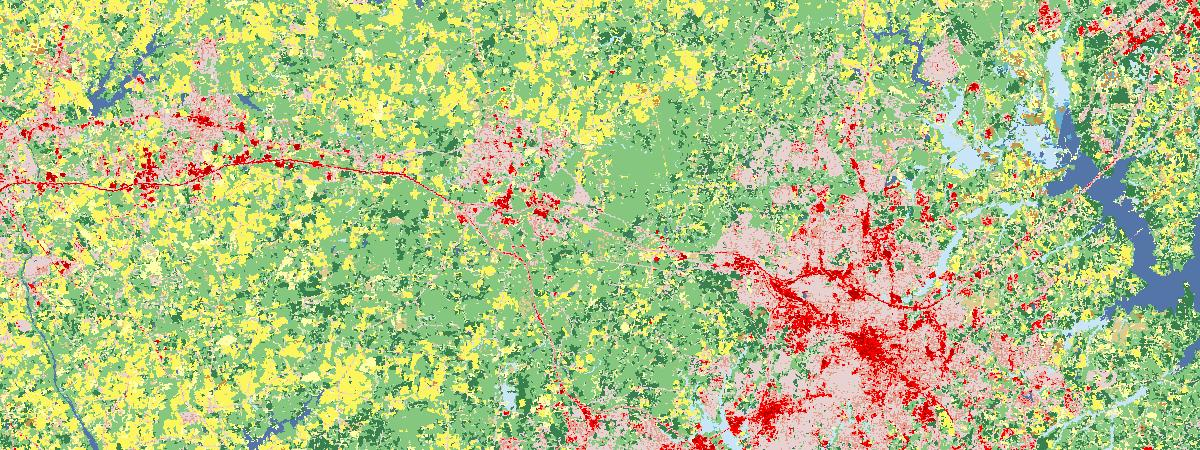

In [17]:
#Have a look at our layer, subset to the extent we provided
lc_lyr.extent =  extentPoly_prj
lc_lyr

In [18]:
from arcgis.raster.functions import clip
lc_clip = clip(raster=lc_lyr,geometry=extentPoly_prj)

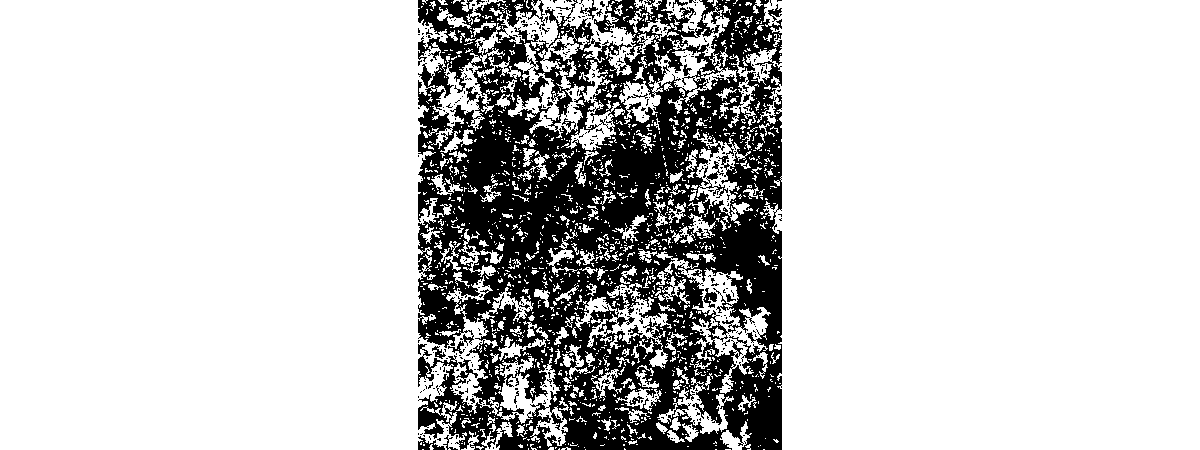

In [19]:
lc_clip

In [20]:
import pandas as pd
attDF = pd.DataFrame.from_records(lc_clip.attribute_table()['features'])
attDF = attDF['attributes'].apply(pd.Series).set_index('OBJECTID')
attDF.head()

Value      Count                   ClassName  Red  Green  Blue
OBJECTID                                                                
1            11  469012527                  Open Water   84    117   168
2            12    1599206          Perennial Snow/Ice  255    255   255
3            21  292251633        Developed Open Space  232    209   209
4            22  131633826     Developed Low Intensity  226    158   140
5            23   59456652  Developed Medium Intensity  255      0     0

In [21]:
#Now we need to compute number of rows and columns contained in this extent
xSize = int((extentPoly_prj.xmax - extentPoly_prj.xmin) / xPixelSize)
ySize = int((extentPoly_prj.ymax - extentPoly_prj.ymin) / xPixelSize)
xSize,ySize

(742, 917)

* Use the imagery layer's [`export_image`](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.raster.toc.html#arcgis.raster.ImageryLayer.export_image) function to extract a subset of data.

In [22]:
#Extract data
img = lc_lyr.export_image(bbox=extentPoly_prj,
                          size=[xSize,ySize],
                          f='image')
type(img)

bytes

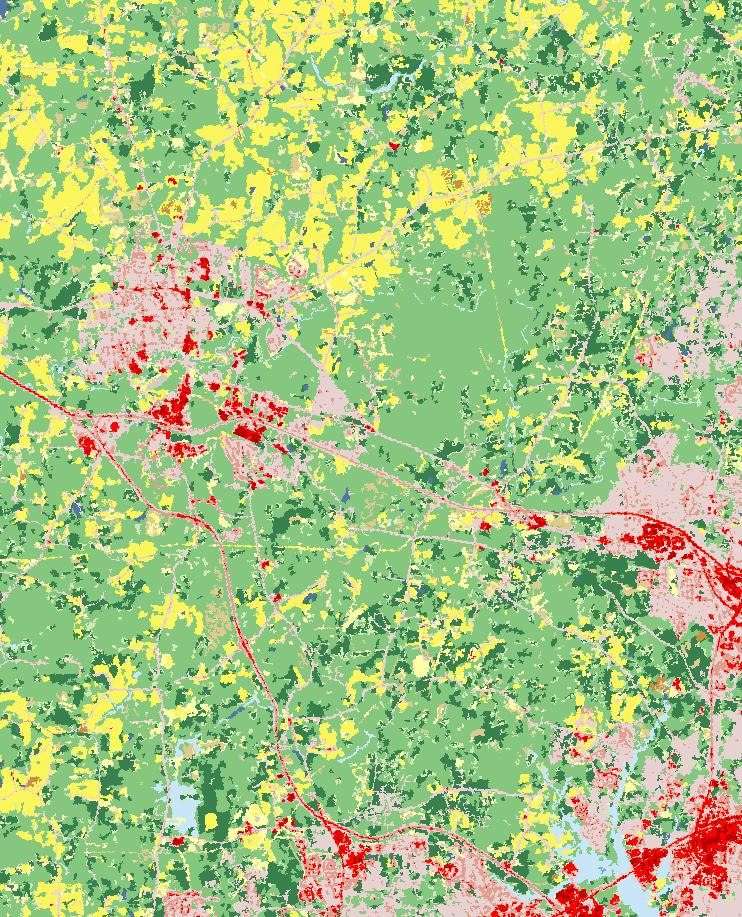

In [23]:
#Show the image
Image(img)

In [24]:
#Or we can save the output directly to a file
savedimg = lc_lyr.export_image(bbox=extentPoly_prj,
                               save_folder='.', 
                               save_file='DurhamNLCD.tif',
                               size=[xSize,ySize],
                               export_format='tiff',
                               compression_quality=100,
                               f='image'
                              )

In [25]:
#Or we can examine properties of our saved image as a JSON object
img_json = lc_lyr.export_image(bbox=extentPoly_prj,
                               f='json'
                              )
img_json

{'href': 'https://landscape10.arcgis.com/arcgis/rest/directories/arcgisoutput/USA_NLCD_Land_Cover_2011_ImageServer/x_____xqmCK9X7n8Q6sueiBso4lag..x_____x_ags_b7cd5055_2df7_4e00_9944_af9c7197d9b7.jpg',
 'width': 1200,
 'height': 450,
 'extent': {'xmin': -8836522.000776479,
  'ymin': 4293743.628389976,
  'xmax': -8763089.493640069,
  'ymax': 4321280.81856613,
  'spatialReference': {'wkid': 102100, 'latestWkid': 3857}},
 'scale': 0}